In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

### Load metadata

In [326]:
metadata = pd.read_csv("../../metadata.csv", sep=";")

### Load features and labels

In [327]:
X = pd.read_csv("../../taxonomy/species_data.csv", sep=";").set_index("Sample", drop=True)
y = pd.read_csv("../../labels.csv", sep=";").set_index("Sample", drop=True)

In [328]:
X = X.drop("Gorilla gorilla", axis=1)
X = X.drop("Homo sapiens", axis=1)

### Select only 1 of 2 datasets

In [329]:
X = X.loc[metadata[metadata["BioProject"] == "PRJNA757365"]["Run"]]
y = y.loc[metadata[metadata["BioProject"] == "PRJNA757365"]["Run"]]["Label"]

## log transformation

In [330]:
# perform a log transformation on the data
X_log = np.log(X + 1)
X_log

,Saccharomyces cerevisiae,Chryseobacterium sp. LAM-KRS1,Pongo abelii,Mangifera indica,Cyprinus carpio,Hylobates moloch,Pipra filicauda,Pan troglodytes,Musa acuminata,Brassica napus,...,Methylonatrum kenyense,Candidatus Nardonella dryophthoridicola,Wohlfahrtiimonas larvae,Buchananvirus Sa179lw,Halospina denitrificans,Dehalogenimonas alkenigignens,Swiduovirus swi2,Shuimuvirus IME207,Akiravirus akira,Pseudohongiella spirulinae
Sample,,,,,,,,,,,,,,,,,,,,,
SRR15595353,0.000000,0.0,9.183380,0.0,0.000000,0.0,0.0,9.354527,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR15595352,0.000000,0.0,9.167224,0.0,0.000000,0.0,0.0,9.356430,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR15595351,0.000000,0.0,9.595875,0.0,0.000000,0.0,0.0,9.810988,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR15595350,0.000000,0.0,0.000000,0.0,0.693147,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR15595349,0.000000,0.0,9.355133,0.0,0.000000,0.0,0.0,9.739791,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR15595248,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR15595247,0.000000,0.0,9.419060,0.0,0.000000,0.0,0.0,9.521275,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR15595246,3.091042,0.0,0.000000,0.0,0.693147,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Normalize features using min-max

In [331]:
min_max_scaler = preprocessing.MinMaxScaler()
X_norm = min_max_scaler.fit_transform(X_log)
X_norm.shape

(80, 477)

# Estimate how many components use for PCA based on explained variance

## Perform PCA

In [332]:
# Perform PCA
pca = PCA()
pca.fit(X_norm)

PCA()

## Calculate the explained variance and Plot the cumulative explained variance

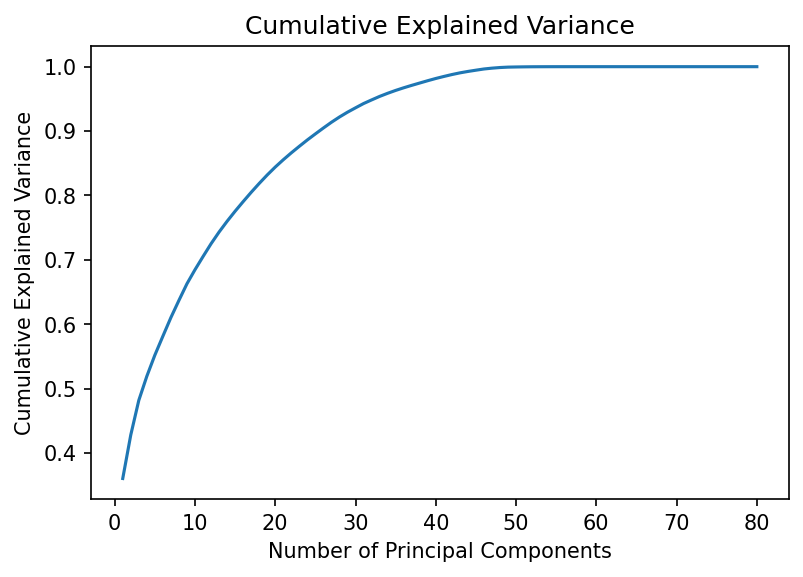

In [333]:
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
fig = plt.figure(dpi=150)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Run models on transformed features

## Instantiate PCA with the desired number of principal components from the previous section and split the data

In [334]:
n_components = 1
pca = PCA(n_components=n_components)

# Fit and transform data
pca.fit(X_norm)
transformed = pca.transform(X_norm)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(transformed, y, test_size=0.3, random_state=42)

## Random Forest

### Grid search RF

In [341]:
param_grid = { 
    'n_estimators': [50, 100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'criterion' :['gini', 'entropy', 'log_loss']
}

rfc = RandomForestClassifier(random_state=42)

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)
CV_rfc.fit(X_train, y_train)

CV_rfc.best_params_

{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 250}

## Accuracy of the best RF found with grid search

In [342]:
rfc_best = RandomForestClassifier(
    criterion=CV_rfc.best_params_["criterion"],
    max_features=CV_rfc.best_params_["max_features"],
    n_estimators=CV_rfc.best_params_["n_estimators"],
    random_state=42,
    n_jobs=-1
)

rfc_best.fit(X_train, y_train)
y_pred = rfc_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.5416666666666666


### Plot confusion matrix for random forest

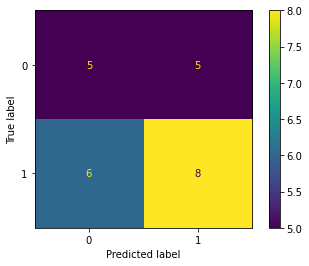

In [343]:
cm = confusion_matrix(y_test, y_pred, labels=rfc_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfc_best.classes_)
disp.plot()
plt.show()

## Logistic Regression

In [344]:
# Fit logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.4166666666666667


## SVM

### linear kernel

In [345]:
# Fit SVM model
model = SVC(kernel='linear')
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.4166666666666667
